In [10]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA

In [11]:
root_path = 'data'
img_files = os.listdir(root_path)
img_files

['soren_1.jpg']

In [12]:
class Context:
    '''
    Clase que permite almacenar el contexto de ejecución de los pasos 
    del pipeline. Esta clase será particularmente útil en el último 
    paso del pipeline donde necesitaremoslos datos generados por todos 
    los pasos del pipeline para imprimir el detalle de los resultados.
    '''
    def __init__(self) -> None :
        self.centroids = None
        self.labels = None

    def transform(self, X, y=None):
        return self

In [13]:
class ImageLoader(BaseEstimator, TransformerMixin) :
    '''
    Este paso del pipeline se encarga de cargar la imagen a partir de un 
    archivo. En este paso se recibe un archivo y se retorna una matriz 
    de pixeles en formato RGB. 
    '''
    def __init__(self, context) -> None:
        self.context = context

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        '''
        Recibe un archivo en el parámetro X y retorna una matriz de 
        pixeles en formato RGB como resultado de la transformación. 
        '''
        img = cv2.imread(os.path.join(root_path, X))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.context.original_img = img
        return img

In [14]:
class ImageProcessor(BaseEstimator, TransformerMixin) :
    '''
    Este paso del pipeline se encarga de hacer el pre-procesamiento 
    necesario para el entrenamiento del modelo. Concretamente, 
    en este paso se recibe una imagen como una matriz de pixeles 
    en RGB se retorna un arreglo de números. El arreglo esta normalizado. 
    '''
    def __init__(self, context, num_components=10) -> None:
        self.context = context
        self.num_components = num_components

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        '''
        Recibe una matriz de pixeles RGB en el parámetro X y retorna un 
        arreglo de tres dimensiones normalizado al rango [0, 1]. 
        '''
        img = X

        # Applicando reducción de la dimensionalidad.
        reduced_img = self.reduce(X, self.num_components)

        # Transformando la imagen en un arreglo de N*3 para facilitar el procesamiento.
        img = reduced_img.reshape((-1, 3))        
        img = img / 255.0

        self.context.normalized_img = img
        self.context.reduced_img = reduced_img
        return img
    
    
    def reduce(self, img, method='pca') :
        x = len(img)    
        y = len(img[0])
        z = len(img[0][0])

        reduced_img = img.reshape((x, y*z))
        pca = PCA(n_components = self.num_components)
        reduced_img = pca.fit_transform(reduced_img)
        reduced_img = pca.inverse_transform(reduced_img)
        reduced_img = reduced_img.reshape((x, y, z))
    
        return reduced_img


In [15]:
class Algorithm(BaseEstimator, TransformerMixin) :
    '''
    ALgorimo de agrupación. Suporta kmeans, AgglomerativeClustering, ...
    '''
    
    def __init__(self, clusterer, context) -> None:
        context.clusterer = clusterer
        self.clusterer = clusterer
        self.context = context

    def fit(self, X, y=None):
        self.clusterer.fit(X, y)
        self.context.labels = self.clusterer.labels_

        if type(self.clusterer) == KMeans:
            self.context.centroids = self.clusterer.cluster_centers_
            
        if type(self.clusterer) == AgglomerativeClustering:
            self.context.centroids = self.compute_color_per_label(self.clusterer.labels_, X)
        
        return self.context

    def transform(self, X):
        return X
    
    def compute_color_per_label(self, labels, colors):
        color_array = []
        centroids = []
        
        for i in range(len(np.unique(labels))) :
            color_array.append([])
            
        for i in range(len(labels)) :
            color_array[labels[i]].append(colors[i])

        for i in range(len(color_array)) :
            centroid = sum(color_array[i]) / len(color_array[i])
            centroids.append(centroid)

        return centroids


num_clusters = 6

# Inicialización del algoritmo de kmeans para la segmentación.
kmeans = KMeans(max_iter=200, n_init=10, n_clusters=num_clusters)

# Inicialización del algoritmo de DBSCAN para la segmentación.
radius = 0.3
dbscan = DBSCAN(eps=20, min_samples=2, n_jobs=-1)

# Inicialización del algoritmo de AgglomerativeClustering para la segmentación.
agglomerativeClustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')

In [16]:
class ImageSegmentation(BaseEstimator, TransformerMixin) :
    '''
    En este paso del pipeline, se segmenta la imagen original generando 
    una máscara a partir de los centroides encontrados por el algoritmo.
    '''
    def __init__(self, context) -> None:
        self.context = context

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        labels = self.context.clusterer.labels_
        centroids = np.array([[0, 0, 255], [255, 255, 255], [0, 255, 255], [255, 0, 255], [255, 255, 0], [255, 255, 255], [0, 255, 0]])
        img = centroids[labels]
        img = img.reshape(self.context.reduced_img.shape)
        self.context.segmented_img = img
        return img

In [17]:
class PrettyPrinter(BaseEstimator, TransformerMixin) :
    '''
    Finalmente, queremos imprimir las imagenes original y 
    segmentada así como la paleta de colores formada por los 
    centroides encontrados por k-means. 
    '''
    def __init__(self, context) -> None:
        self.context = context

    def fit(self, X, y=None):
        figsize = len(self.context.original_img) * 0.0021
        plt.figure(figsize=(10, figsize))

        plt.subplot(1, 3, 1)
        plt.title('Imagen original')
        plt.imshow(self.context.original_img)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title(f'Imagen reducida')
        plt.imshow(self.context.reduced_img)
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Imagen segmentada')
        plt.imshow(self.context.segmented_img.astype(np.uint8))
        plt.axis('off')

        plt.tight_layout()
        plt.show()
        
        print('----')
        print('')

        return self

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


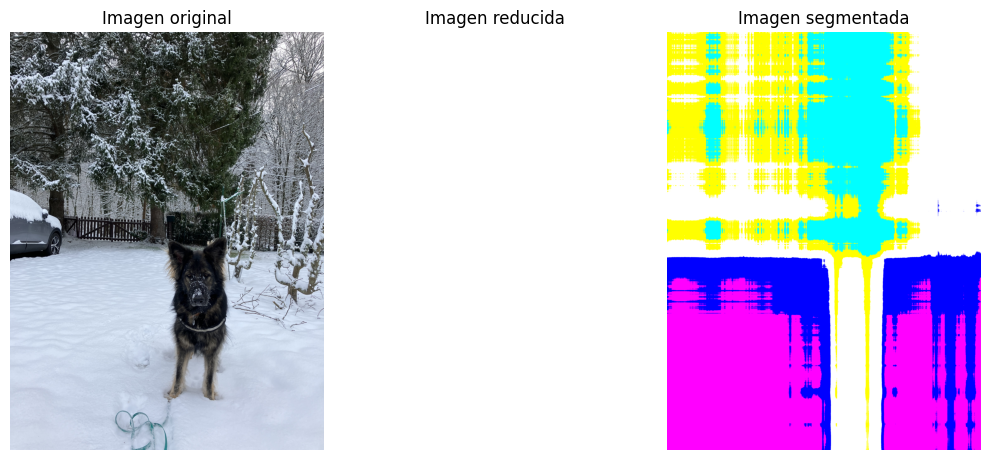

----



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


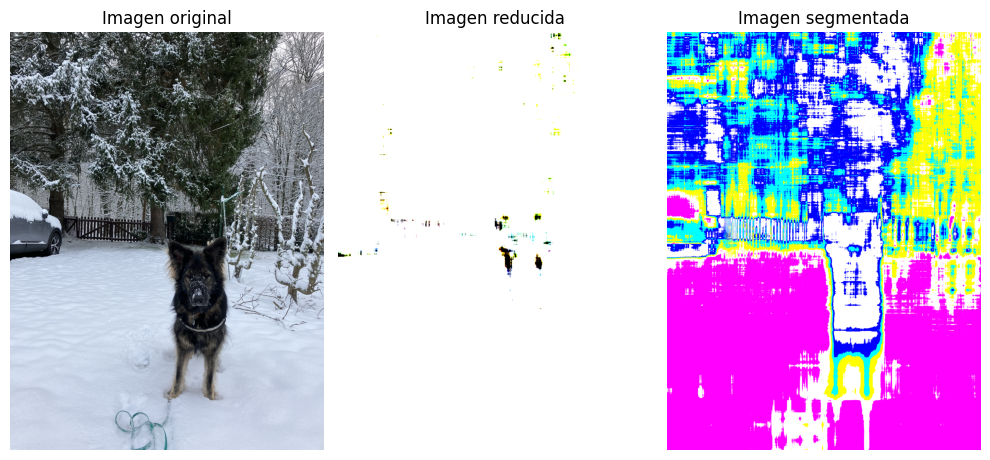

----



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [19]:
pca_components = [1, 10, 20, 50]

for i in range(len(img_files)): 
    for j in range(len(pca_components)):  
        context = Context()
        algorithm = Algorithm(clusterer=kmeans, context=context)
        steps = [
            ("loader", ImageLoader(context)),
            ("processor", ImageProcessor(context, num_components=pca_components[j])),
            ("algorithm", algorithm),
            ("segmentation", ImageSegmentation(context)),
            ("prettyPrinter", PrettyPrinter(context))
        ]
        pipeline = Pipeline(steps)
        pipeline.fit(img_files[i])